# Supervised Learning: K-Nearest Neighbors
Author: Neil Ashtekar

We will apply machine learning to a university admittance dataset. Using historical exam data and admittance records, we will create a classifier that determines if an applicant will be admitted given their exam scores. We will use the k-nearest neighbors algorithm, implemented without scikit-learn.

 
Start by importing necessary packages and loading our dataset.

In [24]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
plt.rcParams['figure.figsize'] = [8, 6]

In [25]:
# get dataset
data = pd.read_csv('exam_scores.csv')
data.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Looking at the first few datapoints, it appears that students who got high scores on both exams were admitted to the university, while those with low scores were not admitted. Let's setup our features and labels, and visualize the data.

In [26]:
# setup features X and labels y
X = data.values[:, [0, 1]]
y = data.values[:, -1]

In [27]:
# visualize data
def viz(show=True):
    """ Creates visualization of all training points and corresponding admittance """
    for i in range(X.shape[0]):
        if y[i] == 1:
            plt.scatter(X[i, 0], X[i, 1], color='green')
        else:
            plt.scatter(X[i, 0], X[i, 1], color='red')
    plt.title('Exam Score vs Admittance')
    plt.xlabel('Exam 1 Score')
    plt.ylabel('Exam 2 Score')
    if show:
        plt.show()
    return None

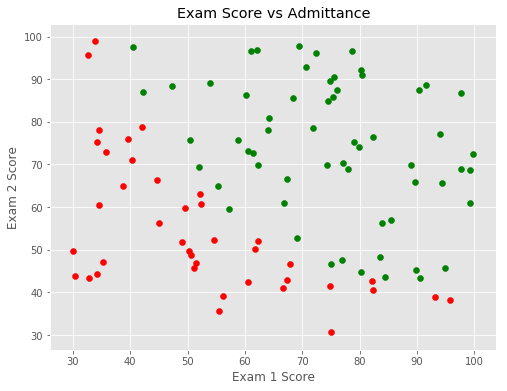

In [28]:
viz()

Looks like we were right -- students who did well on both exams were usually admitted, while students who did poorly on each exam were usually denied. Let's create a k-nearest neighbors classifier to make predictions on future applicants.

In [29]:
# create classifier
def predict(inputs, k=5, show=True, perform_return=False):
    """ Makes prediction on a single new point, input form [exam1_score, exam2_score]"""
    # iterate over all points, finding distance between training points and test point
    distances = []
    for i in range(X.shape[0]):
        distances.append(np.sqrt((X[i, 0] - inputs[0]) ** 2 + (X[i, 1] - inputs[1]) ** 2))
        
    # find the indices of the k smallest distances (k nearest neighbors)
    nearest_neighbors = np.argpartition(distances, k)
    
    # if more than half of the k nearest neighbors were admitted, predict admitted    
    if np.sum((y[nearest_neighbors[:k]] == 1).astype(int)) > k / 2:
        admit = 1
        
    # if more than half of the k nearest neighbors were denied, predict denied
    elif np.sum((y[nearest_neighbors[:k]] == 1).astype(int)) < k / 2:
        admit = 0
        
    # otherwise, unable to make a prediction
    else:
        admit = None
        
    # plot test point, k-nearest neighbors
    if show:
        print('\n\nPredicts Admitted') if admit else print('\n\nPredicts Denied')
        viz(show=False)
        plt.scatter(inputs[0], inputs[1], color='black', s=100)
        plt.scatter(X[nearest_neighbors[:k], 0], X[nearest_neighbors[:k], 1], 
                   color='black', marker='x', s=100)
        plt.show()
    
    # return admittance if specified
    return (None if not perform_return else admit)

Now that our classifier is made, we can start making predictions!



Predicts Admitted


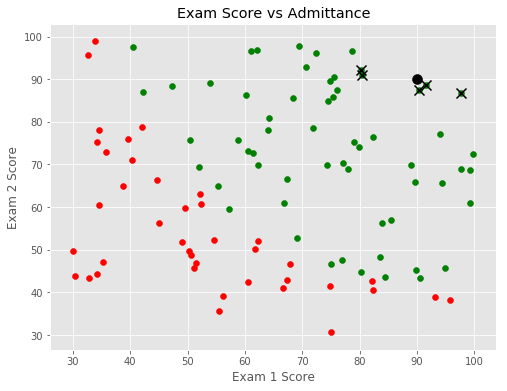



Predicts Denied


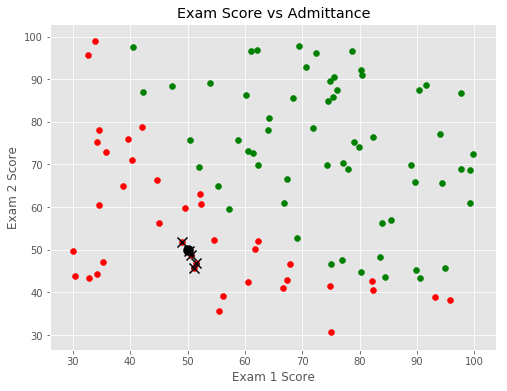



Predicts Denied


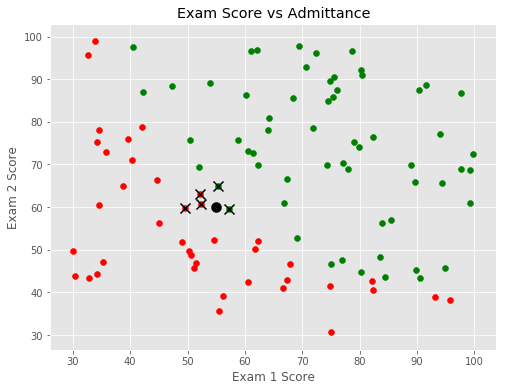

In [30]:
# make some predictions
predict([90, 90], k=5)
predict([50, 50], k=5)
predict([55, 60], k=5)

Our classifier seems to be working for k = 5! Let's try out different k values. Remember that k should be odd -- we have two classes, and we need a majority to make a prediction.



Predicts Denied


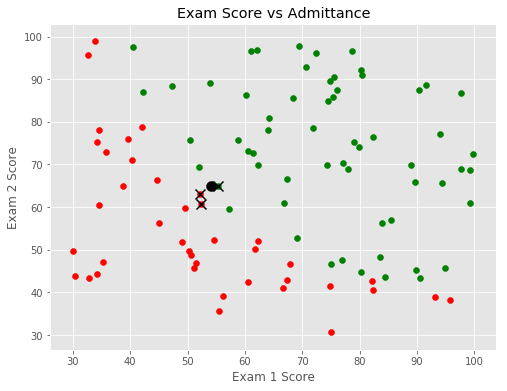



Predicts Admitted


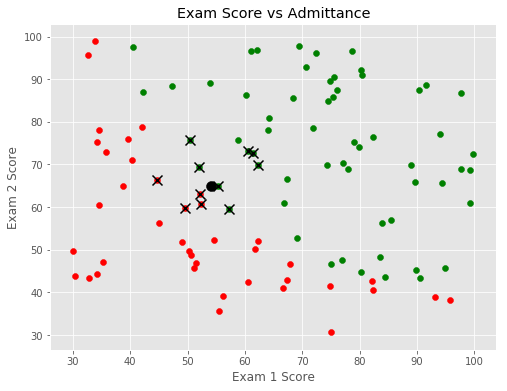

In [31]:
# try out different numbers of neighbors (k should be odd)
predict([54, 65], k=3)
predict([54, 65], k=11)

Note that in the above example, different k values resulted in different predictions for the same point!
    
To choose the best value of k, let's use cross validation. We will break up our training set into a training and validation set, and make predictions on the validation set. We then use whichever k value did best on the validation set.

In [32]:
# randomize data
data = data.sample(frac=1).reset_index(drop=True)
print(data.head(), '\n')

# break data into training (70%) and validation sets (30%)
Xtrain = data.values[:70, [0, 1]]
ytrain = data.values[:70, -1]
Xval = data.values[70:, [0, 1]]
yval = data.values[70:, -1]

# to check that samples are representative
print('Proportion of admittances in train:     ', np.sum(ytrain) / 70, 
      '\nProportion of admittances in validation:', np.sum(yval) / 30)

       exam1      exam2   admitted
0  38.785804  64.995681          0
1  53.971052  89.207350          1
2  35.286113  47.020514          0
3  33.915500  98.869436          0
4  60.182599  86.308552          1 

Proportion of admittances in train:      0.628571428571 
Proportion of admittances in validation: 0.533333333333


Now, find the best value of k by making predictions on validation set.

In [33]:
most_correct = 0

# test k from 1 - 25
for k in range(1, 26):
    correct = 0
    for i in range(Xval.shape[0]):
        correct += (int(predict(inputs=Xval[i], k=k, show=False, perform_return=True) == y[i]))
    if correct > most_correct:
        most_correct = correct
        best_k = k

print('Best k value:', best_k)

Best k value: 23


Well, it looks like we don't have enough data to find a meaningful best k value. Our program gives us very different values for best k depending on the random split of train and validation. Given that we only have 100 data points, this makes sense. It may be more valuable just to look at some decision boundaries for various k values.

In [34]:
def decision_boundary(k):
    """ Plots decision boundary (shaded region) for given k """
    print('\n\nDecision Boundary for k =', k)

    X1 = np.linspace(min(X[:, 0]), max(X[:, 1]), 50)
    X2 = np.linspace(min(X[:, 1]), max(X[:, 1]), 50)
    
    # plot a bunch of large points covering all possible exam scores
    for i in X1:
        for j in X2:
            if predict(inputs=[i, j], k=k, show=False, perform_return=True) == 1:
                plt.scatter(i, j, color='lightgreen', s=100)
            elif predict(inputs=[i, j], k=k, show=False, perform_return=True) == 0:
                plt.scatter(i, j, color='lightpink', s=100)

    # plot actual data on top
    viz(show=False)
    plt.show()
    return None

Now that we've made a function to determine decision boundaries, let's see some!



Decision Boundary for k = 1


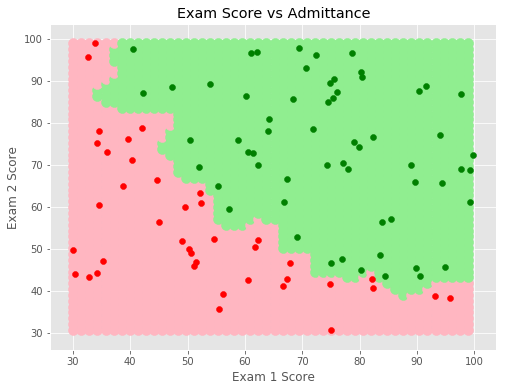

In [35]:
decision_boundary(1)

k = 1 results in a jagged decision boundary. Let's try k = 2.



Decision Boundary for k = 2


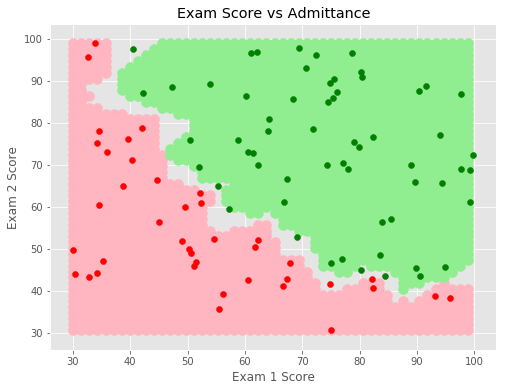

In [36]:
decision_boundary(2)

Notice how k = 2 results in some areas left unclassified. This is because some areas have 'divided' nearest neighbors: one green nearest neighbor and one red nearest neighbor. The algorithm cannot classify these points. Now try k = 5:



Decision Boundary for k = 5


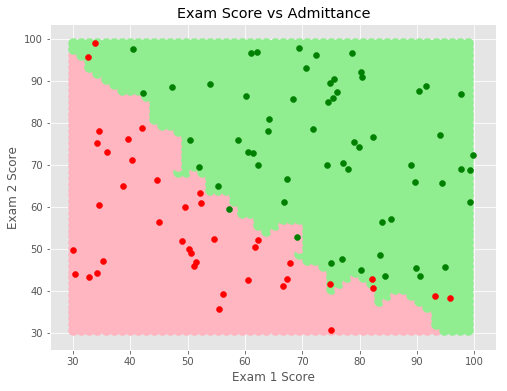

In [37]:
decision_boundary(5)

The decision boundary for k = 5 is smoother than k = 1 or k = 2, and leaves no points unclassified. What about a higher k?



Decision Boundary for k = 25


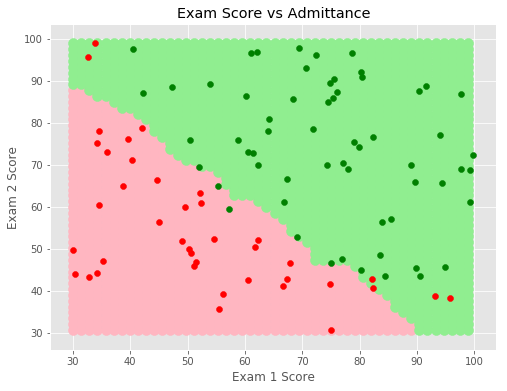

In [38]:
decision_boundary(25)

The decision boundary for k = 25 is even smoother, to the extent that some points are misclassified!

### K-Nearest Neighbors is a simple but powerful classifier.
This example might seem trivial, but the point is to illustrate how the algorithm works. Intuitively, k-nearest neighbors uses distance to classify points based on similarity. K-Nearest Neighbors is a powerful classifier that works in applications including:
- handwritten digit recognition
- plant or animal species classification
- economic forecasting
